In [1]:
import dask.dataframe as dd
from dask.dataframe.utils import make_meta
from neo4j import GraphDatabase
from neo4j.exceptions import ClientError
from dask.distributed import Client, LocalCluster, get_worker
import dask
import pickle
import dill
import json

import os
import time
from tqdm import tqdm
import pandas as pd
import re

# from pm4py.discovery import discover_petri_net_inductive as inductive_miner
# from pm4py.discovery import discover_petri_net_alpha as alpha_miner
# from pm4py.discovery import discover_petri_net_heuristics as heuristics_miner
# from pm4py.discovery import discover_dfg_typed
# from pm4py.conformance import fitness_alignments, fitness_token_based_replay
# from pm4py import serialize, deserialize

from pm4py import discover_dfg_typed as dfg_discovery, serialize, deserialize
from pm4py.algo.discovery.alpha import algorithm as alpha_miner
from pm4py.algo.discovery.heuristics import algorithm as heuristics_miner
from pm4py.algo.discovery.inductive import algorithm as inductive_miner
from pm4py.algo.evaluation.simplicity import algorithm as simplicity_evaluator
from pm4py.algo.evaluation.replay_fitness import algorithm as replay_fitness_evaluator
from pm4py.algo.evaluation.precision import algorithm as precision_evaluator
from pm4py.algo.evaluation.generalization import algorithm as generalization_evaluator

In [17]:
import sys
sys.setrecursionlimit(30000)

In [2]:
class graph_driver():
    def __init__(self, uri_scheme='bolt', host='localhost', port='7687', username='neo4j', password='123456'):
        self.uri_scheme = uri_scheme
        self.host = host
        self.port = port
        
        self.username = username
        self.password = password
        
        self.connection_uri = "{uri_scheme}://{host}:{port}".format(uri_scheme=self.uri_scheme, host=self.host, port=self.port)
        self.auth = (self.username, self.password)
        self.driver = GraphDatabase.driver(self.connection_uri, auth=self.auth)
        
    def __del__(self):
        self._close_driver()
    
    def _close_driver(self):
        if self.driver:
            self.driver.close()
    
    def run_single_query(self, query):
        res = None
        with self.driver.session() as session:
            raw_res = session.run(query)
            res = self.format_raw_res(raw_res)
        return res
    
    def run_bulk_query(self, query_list):
        results = []
        with self.driver.session() as session:
            for query in tqdm(query_list):
                raw_res = session.run(query)
                res = self.format_raw_res(raw_res)
                results.append({'query':query, 'result':res})
        return results
    
    def reset_graph(self, db=None):
        return self.run_single_query("MATCH (n) DETACH DELETE n")
    
    def test_connection(self):
        return self.run_single_query("MATCH (n) RETURN COUNT(n) as nodes")
    
    @staticmethod
    def format_raw_res(raw_res):
        res = []
        for r in raw_res:
            res.append(r)
        return res

In [3]:
def convertToDFG(records):
    dfg = {}
    for record in records:
        r = record.data()
        dfg[(r["Parent"], r["Child"])] = float(r["Frequency"])
    return dfg

In [4]:
columnTypes = {
    'case:IDofConceptCase': 'string',
    'case:Includes_subCases': 'string',
    'case:Responsible_actor': 'string',
    'case:caseProcedure': 'string',
    'case:concept:name': 'string',
    'dateStop': 'string'
}
df = dd.read_csv('BPIC15_1.csv', dtype=columnTypes)
for column in df.columns:
    if re.search("[Dd]ate.*|time.*", column):
        df[column] = dask.dataframe.to_datetime(df[column], utc=True)

In [5]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 5
Total threads: 5,Total memory: 7.67 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:38851,Workers: 5
Dashboard: http://127.0.0.1:8787/status,Total threads: 5
Started: Just now,Total memory: 7.67 GiB
Comm: tcp://127.0.0.1:46327,Total threads: 1
Dashboard: http://127.0.0.1:44257/status,Memory: 1.53 GiB
Nanny: tcp://127.0.0.1:37147,


In [6]:
df['successor'] = ''
df['predecessor'] = ''
df = df.sort_values(by='time:timestamp')

In [7]:
def getDFGQueries(dfg):
    listOfQueries = []
    queryTemplate = """
        MERGE (p:Activity {{name: '{parent}'}})
        MERGE (c:Activity {{name: '{child}'}})
        MERGE (p)-[r:PRODUCES {{frequency: '{frequency}'}}]->(c)
    """
    for parent, child in dfg:
        frequency = dfg[(parent, child)]
        template = queryTemplate.format(parent=parent, child=child, frequency=frequency)
        listOfQueries.append(template)
    return listOfQueries

In [8]:
def saveDFG(dfg):
    dfgResult = dfg_discovery(dfg)
    dfgQuery = getDFGQueries(dfgResult.graph)
    neo4jConnection = graph_driver(uri_scheme="neo4j",host="neo4j", password="123456")
    result = neo4jConnection.run_bulk_query(dfgQuery)
    return dfgResult

In [9]:
lazyDFG = dask.delayed(saveDFG)(df)

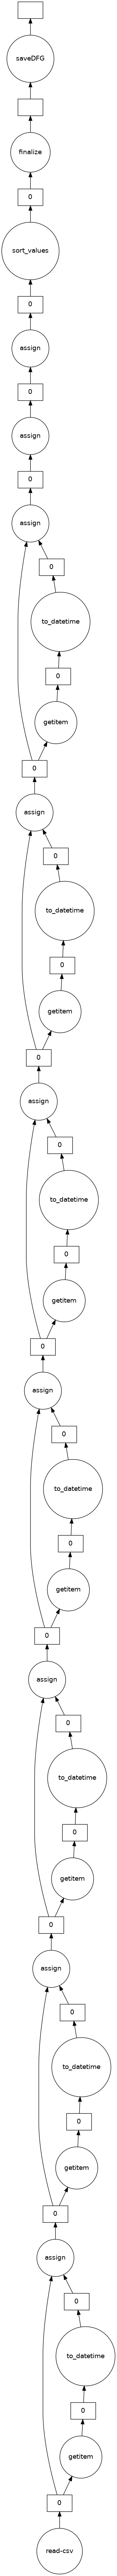

In [12]:
lazyDFG.visualize()

In [13]:
dfg_output = dask.compute(lazyDFG)[0] # hosted locally

100%|██████████| 6111/6111 [00:25<00:00, 236.29it/s]


In [14]:
# neo4jConnection = graph_driver(uri_scheme="neo4j",host="neo4j", password="123456")
# readQuery = """
#     MATCH result=(p:Activity)-[r:PRODUCES]->(c:Activity) 
#     RETURN p.name as Parent, c.name as Child, r.cost as Frequency"""
# result = neo4jConnection.run_single_query(readQuery)

In [15]:
def getMinerResult(dfg, miner, threshold = 0.5):
    result = {}
    if miner == 'heuristic_miner':
        net, im, fm = heuristics_miner.apply_dfg(dfg, parameters={heuristics_miner.Variants.CLASSIC.value.Parameters.DEPENDENCY_THRESH: threshold})
    elif miner == 'inductive_miner':
        net, im, fm = inductive_miner(dfg, noise_threshold=0.9, multi_processing=True)
    elif miner == 'alpha_miner':
        net, im, fm = alpha_miner(dfg)
    
    result[miner] = serialize(net, im, fm)
    return result
    
def setLazyMiners(dfg):
    lazyList = []
    miners = [
        'heuristic_miner', 
#         'inductive_miner', 
#         'alpha_miner'
    ]
    for miner in miners:
        lazyList.append(dask.delayed(getMinerResult)(dfg, miner))
    
    return lazyList

In [37]:
def getMetrics(metric, log, petrinet, im, fm):
    result = {}
    if metric == 'fitness':
        result[metric] = replay_fitness_evaluator.apply(log, petrinet, im, fm)
    
    return result

def setLazyMetrics(dfg, petrinet, im, fm):
    lazyList = []
    metrics = ['fitness']
    
    for metric in metrics:
        lazyList.append(dask.delayed(getMetrics)(metric, dfg, petrinet, im, fm))
    
    return lazyList

In [18]:
lazyMiners = setLazyMiners(dfg_output.graph)

In [29]:
lazyMinersResults = dask.compute(*lazyMiners)

In [31]:
net, im, fm = deserialize(lazyMinersResults[0]['heuristic_miner'])

In [38]:
lazyMetrics = setLazyMetrics(df, net, im, fm)

In [39]:
lazyMetricsResults = dask.compute(*lazyMetrics)

replaying log with TBR, completed variants :: 100%|██████████| 1180/1180 [58:07<00:00,  2.96s/it]   
